# Agricultural Land Area (percentage of total land area)
In this notebook we will predict agricultural land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing agricultural data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging the forest area percentage variable  

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Mixed effect linear regression base line models
    - Fitting baseline model (mean model)
    - Fitting simple mixed effects model (time, population)
    
- Mixed effect linear regression theory driven models (social)
    - Social theory driven model 
    - Full social model 

- Mixed effect linear regression theory driven models (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_csv('Data/agricultural_land_percent.csv', skiprows=4)



Removing 0 count countries and non-ISO countries.

In [6]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

#Removing zero count columns from data
df_full = df.drop(columns=columns_with_zero_count)

print(df_full)

                    Country Name Country Code  \
0                          Aruba          ABW   
1    Africa Eastern and Southern          AFE   
2                    Afghanistan          AFG   
3     Africa Western and Central          AFW   
4                         Angola          AGO   
..                           ...          ...   
261                       Kosovo          XKX   
262                  Yemen, Rep.          YEM   
263                 South Africa          ZAF   
264                       Zambia          ZMB   
265                     Zimbabwe          ZWE   

                         Indicator Name  Indicator Code       1961       1962  \
0    Agricultural land (% of land area)  AG.LND.AGRI.ZS  11.111111  11.111111   
1    Agricultural land (% of land area)  AG.LND.AGRI.ZS  42.345489  42.328470   
2    Agricultural land (% of land area)  AG.LND.AGRI.ZS  57.878356  57.955016   
3    Agricultural land (% of land area)  AG.LND.AGRI.ZS  32.890182  32.941914   
4    A

In [7]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_full[df_full['Country Code'].isin(ISO_list)]


In [9]:
#Making df long
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='agricultural_land')

melted_df['Year'] = melted_df['Year'].astype(float)

print(melted_df)

      Country Code  Country Name                      Indicator Name  \
0              ABW         Aruba  Agricultural land (% of land area)   
1              AFG   Afghanistan  Agricultural land (% of land area)   
2              AGO        Angola  Agricultural land (% of land area)   
3              ALB       Albania  Agricultural land (% of land area)   
4              AND       Andorra  Agricultural land (% of land area)   
...            ...           ...                                 ...   
13110          WSM         Samoa  Agricultural land (% of land area)   
13111          YEM   Yemen, Rep.  Agricultural land (% of land area)   
13112          ZAF  South Africa  Agricultural land (% of land area)   
13113          ZMB        Zambia  Agricultural land (% of land area)   
13114          ZWE      Zimbabwe  Agricultural land (% of land area)   

       Indicator Code    Year  agricultural_land  
0      AG.LND.AGRI.ZS  1961.0          11.111111  
1      AG.LND.AGRI.ZS  1961.0    

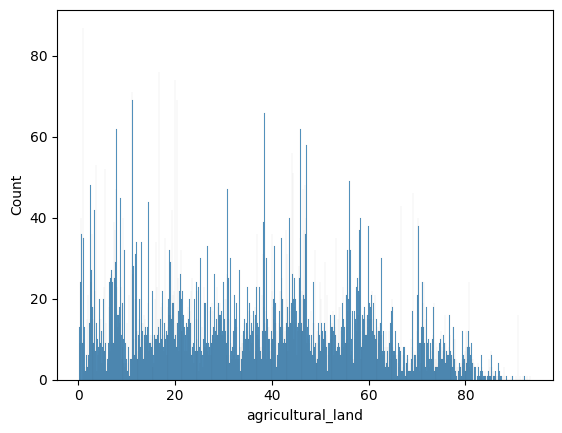

In [10]:
sns.histplot(data=melted_df, x='agricultural_land', binwidth=0.1)
plt.show()

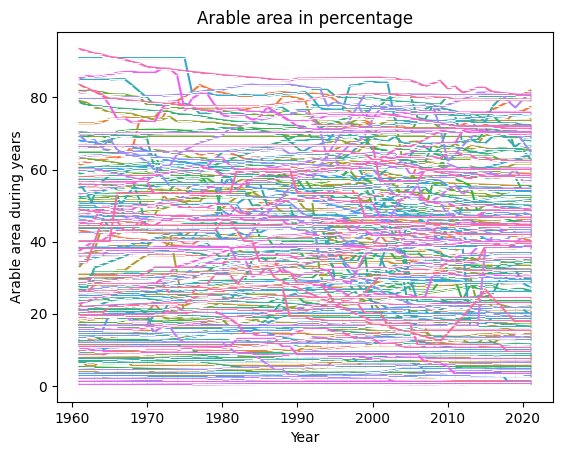

In [14]:
sns.lineplot(data=melted_df, x='Year', y='agricultural_land', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Arable area in percentage')
plt.xlabel('Year')
plt.ylabel('Arable area during years')


# Show the plot
plt.show()

### Combine with predictor data 

In [12]:
#Changing name 
agro = melted_df

In [11]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [14]:
#Renaming so no double names
agro = agro.rename(columns={'Country Name':'Country'})

#combining forest and pred data
agro_full = pd.merge(agro, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
agro_full = agro_full.drop(columns=['Country'])

display(agro_full)

,Country Code,Indicator Name,Indicator Code,Year,agricultural_land,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,ABW,Agricultural land (% of land area),AG.LND.AGRI.ZS,1961.0,11.111111,Aruba,55811.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Agricultural land (% of land area),AG.LND.AGRI.ZS,1961.0,57.878356,Afghanistan,8790140.0,652230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,Agricultural land (% of land area),AG.LND.AGRI.ZS,1961.0,36.237266,Angola,5441333.0,1246700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Agricultural land (% of land area),AG.LND.AGRI.ZS,1961.0,44.963504,Albania,1659800.0,27400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AND,Agricultural land (% of land area),AG.LND.AGRI.ZS,1961.0,55.319149,Andorra,10216.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,YEM,Agricultural land (% of land area),AG.LND.AGRI.ZS,2021.0,44.419190,"Yemen, Rep.",32981641.0,527970.0,-1.680930,-2.580310,-2.324521,-2.040683,-1.802895,-1.668239,NaN,20.0,NaN,16.988239,NaN
13928,YEM,Agricultural land (% of land area),AG.LND.AGRI.ZS,2021.0,44.419190,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695925
13929,ZAF,Agricultural land (% of land area),AG.LND.AGRI.ZS,2021.0,79.417850,South Africa,59392255.0,1213090.0,0.770391,-0.750981,-0.071013,-0.090709,0.069080,-0.034114,25.23908,1804.0,NaN,58.085488,0.422920
13930,ZMB,Agricultural land (% of land area),AG.LND.AGRI.ZS,2021.0,32.067959,Zambia,19473125.0,743390.0,-0.369448,0.052348,-0.841102,-0.570348,-0.607838,-0.759728,NaN,13.0,NaN,34.908994,0.762396


In [16]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
agro_full_filtered = agro_full[(agro_full['Year'] >= 1996) & (agro_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = agro_full_filtered[
    (agro_full_filtered['agricultural_land'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))


204
215


In [17]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = agro_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
agro_full_filtered = agro_full_filtered[agro_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

192
215


In [18]:
# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = agro_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

Countries removed using country code: ['STP', 'ASM', 'GRL', 'KGZ', 'CIV', 'VIR', 'SWZ', 'EGY', 'COG', 'BHS', 'GUM', 'VCT', 'MKD', 'PRK', 'MDA', 'VNM', 'LBY', 'CPV', 'PRI', 'IRN', 'FSM', 'LIE', 'BOL', 'TZA', 'CZE', 'CYM', 'YEM', 'HKG', 'BMU', 'GMB', 'KOR', 'LAO', 'ABW', 'KNA', 'TUR', 'VEN', 'SVK', 'LCA']
154
215


In [19]:
print(agro_full_filtered.isna().sum())

Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Country Name             0
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                  28
WGI GE                  64
WGI RQ                  64
WGI RL                   1
WGI CC                  54
Education             1191
Innovation            1528
Social Inequality     2107
ICT                    784
Health                   0
dtype: int64


We end up with 154 countries and very few NaN in relevant columns.

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = agro_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
agro_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)


Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [24]:
print(agro_full_imputed.isna().sum())

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Education             1191
Innovation            1528
Social Inequality     2107
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64


In [34]:
agro_full_imputed = agro_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
agro_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3388 non-null   object 
 1   Country Name        3388 non-null   object 
 2   Year                3388 non-null   float64
 3   agricultural_land   3388 non-null   float64
 4   Population, total   3388 non-null   float64
 5   Land area (sq. km)  3388 non-null   float64
 6   WGI VA              3388 non-null   float64
 7   WGI PS              3388 non-null   float64
 8   WGI GE              3388 non-null   float64
 9   WGI RQ              3388 non-null   float64
 10  WGI RL              3388 non-null   float64
 11  WGI CC              3388 non-null   float64
 12  ICT                 3388 non-null   float64
 13  Health              3388 non-null   float64
dtypes: float64(12), object(2)
memory usage: 370.7+ KB


Delaying the forest area variable.

In [35]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
agro_full_imputed['lagged_agro'] = pd.NA

#Iterating over each row
for i in range(len(agro_full_imputed)):
    country = agro_full_imputed.loc[i, 'Country Code']
    year = agro_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = agro_full_imputed[(agro_full_imputed['Country Code'] == country) & (agro_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        agro_full_imputed.loc[i, 'lagged_agro'] = lagged_row['agricultural_land'].values[0]

#Display the new dataframe 
display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,57.889088,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,57.945817
1,AFG,Afghanistan,1998.0,58.059274,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,57.939684
2,AFG,Afghanistan,2000.0,57.945817,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,58.151266
3,AFG,Afghanistan,2002.0,57.939684,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,58.123668
4,AFG,Afghanistan,2003.0,58.083805,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,58.129801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,ZWE,Zimbabwe,2016.0,41.876696,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,41.876696
3384,ZWE,Zimbabwe,2017.0,41.876696,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3385,ZWE,Zimbabwe,2018.0,41.876696,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3386,ZWE,Zimbabwe,2019.0,41.876696,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [36]:
#Checking if the lagged is correct 
print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 2000.0)]['agricultural_land'])

print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 1996.0)]['lagged_agro'])

3368    38.929818
Name: agricultural_land, dtype: float64
3366    38.929818
Name: lagged_agro, dtype: object


In [37]:
agro_full_imputed['lagged_agro'] = pd.to_numeric(agro_full_imputed['lagged_agro'])
agro_full_imputed = agro_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
agro_full_imputed = agro_full_imputed.rename(columns={'Population, total':'population'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI VA':'WGI_va'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
agro_full_imputed =agro_full_imputed.dropna()

display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,57.889088,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,57.945817
1,AFG,Afghanistan,1998.0,58.059274,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,57.939684
2,AFG,Afghanistan,2000.0,57.945817,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,58.151266
3,AFG,Afghanistan,2002.0,57.939684,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,58.123668
4,AFG,Afghanistan,2003.0,58.083805,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,58.129801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,ZWE,Zimbabwe,2012.0,41.876696,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,41.876696
3380,ZWE,Zimbabwe,2013.0,41.876696,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,41.876696
3381,ZWE,Zimbabwe,2014.0,41.876696,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,41.876696
3382,ZWE,Zimbabwe,2015.0,41.876696,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,41.876696


In [39]:
print(agro_full_imputed.isna().sum())
print(len(agro_full_imputed['Country Code'].unique()))

Country Code         0
Country Name         0
Year                 0
agricultural_land    0
population           0
land_area            0
WGI_va               0
WGI_ps               0
WGI_ge               0
WGI_rq               0
WGI_rl               0
WGI_cc               0
ICT                  0
Health               0
lagged_agro          0
dtype: int64
154


### Save combined clean data 

In [40]:
agro_full_imputed.to_csv('git_data/agricultural-modelling.csv', index=False)

# Data exploration

In [44]:
#Load in cleaned data 
agro = pd.read_csv('git_data/agricultural-modelling.csv')

agro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       2772 non-null   object 
 1   Country Name       2772 non-null   object 
 2   Year               2772 non-null   float64
 3   agricultural_land  2772 non-null   float64
 4   population         2772 non-null   float64
 5   land_area          2772 non-null   float64
 6   WGI_va             2772 non-null   float64
 7   WGI_ps             2772 non-null   float64
 8   WGI_ge             2772 non-null   float64
 9   WGI_rq             2772 non-null   float64
 10  WGI_rl             2772 non-null   float64
 11  WGI_cc             2772 non-null   float64
 12  ICT                2772 non-null   float64
 13  Health             2772 non-null   float64
 14  lagged_agro        2772 non-null   float64
dtypes: float64(13), object(2)
memory usage: 325.0+ KB


### Plotting and data exploration

Agro area per country over years.

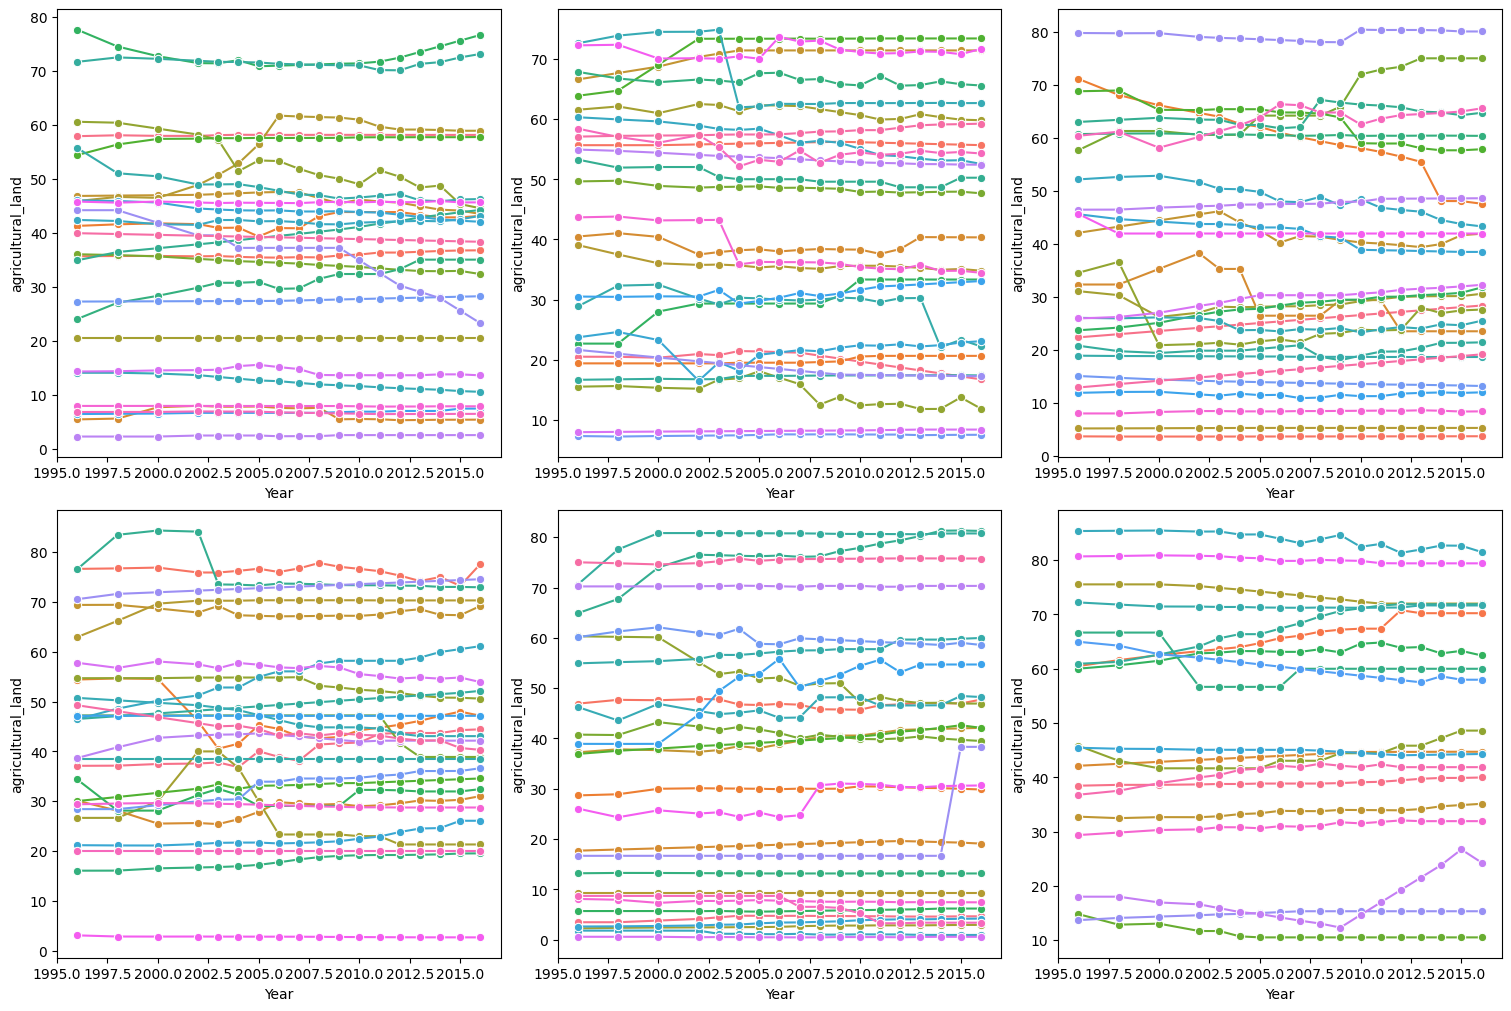

In [45]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='agricultural_land', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

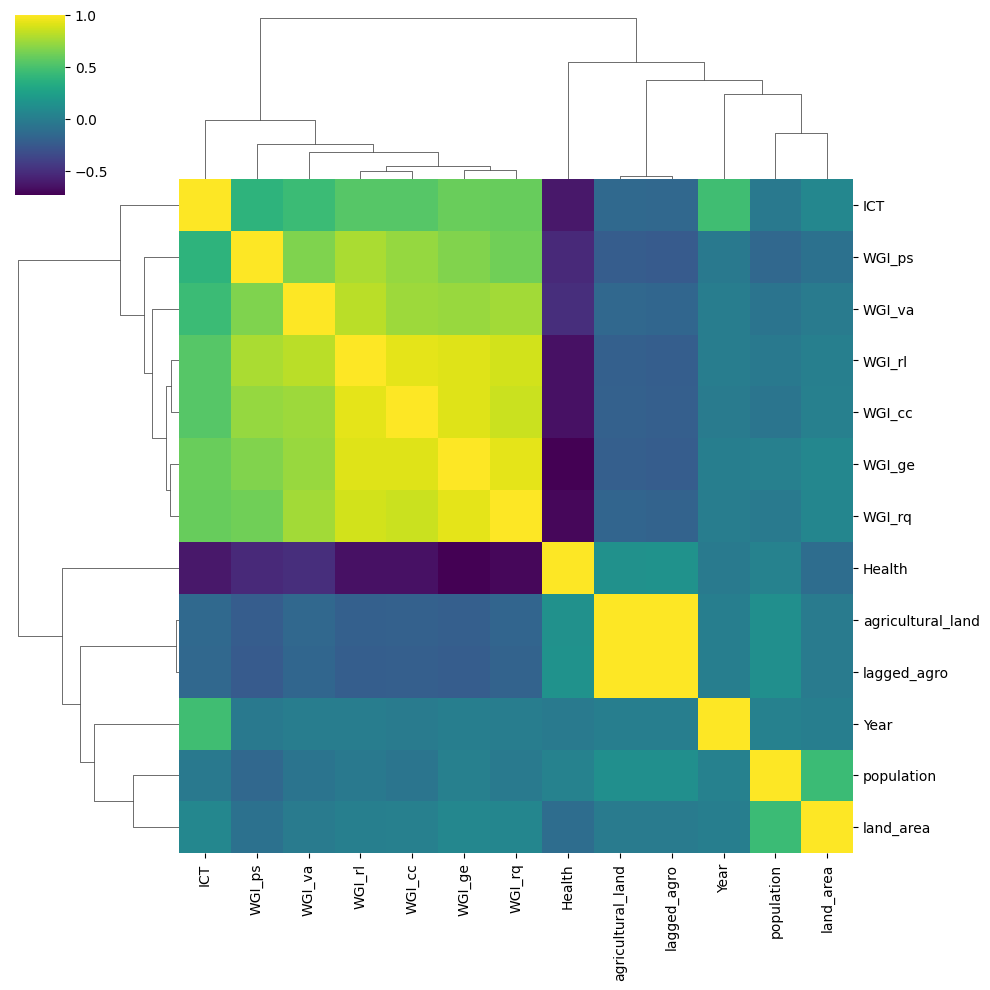

In [48]:
agro_num = agro[agro.select_dtypes(exclude=['object']).columns]

sns.clustermap(agro_num.corr(), cmap='viridis')
plt.show()

### Checking for outliers 

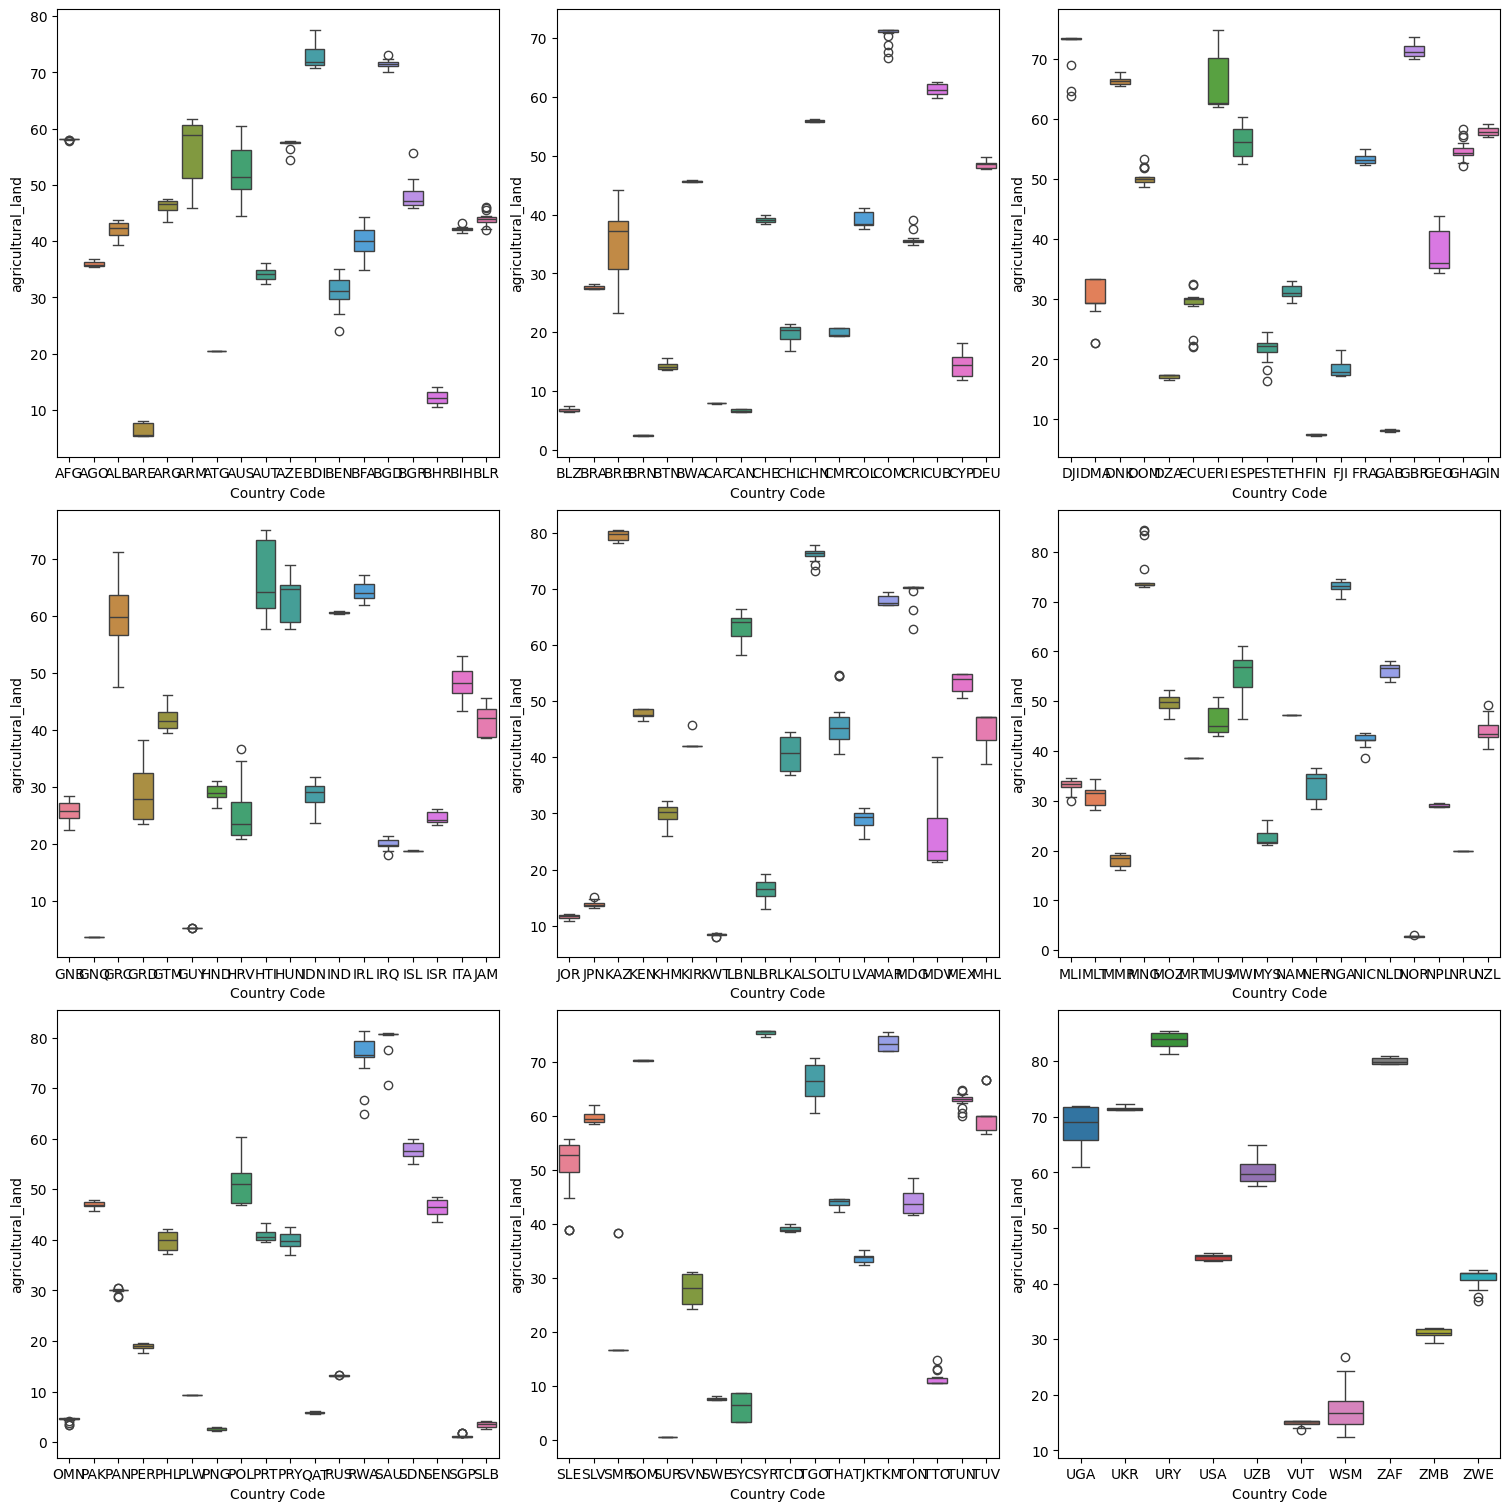

In [51]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 18
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='agricultural_land', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'')
    #ax.set_xlabel('')
    #ax.set_ylabel('')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [53]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_agro'].quantile(0.25)
    Q3 = group['lagged_agro'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_agro'] < lower_bound) | (group['lagged_agro'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = agro.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')
print(f'Number of countries with 2 or more outliers: {(outliers_per_country > 4).sum()}')
print(f'Max number of outliers per country: {max(outliers_per_country)}')


Total number of outliers: 141

Number of outliers per 'Country Code':
Country Code
AFG    6
ARM    3
AUS    2
BGD    2
BGR    3
BRN    4
BWA    5
COM    2
DJI    1
DOM    2
DZA    2
ERI    6
EST    2
FIN    2
FJI    2
GEO    2
GHA    2
GUY    3
IND    6
ISL    6
ISR    4
KHM    1
LBN    2
LTU    1
LVA    3
MDG    3
MDV    3
MMR    2
MNG    2
MUS    2
NAM    4
NER    3
NPL    2
OMN    2
PAN    2
PER    2
POL    1
RUS    5
SGP    2
SLE    2
SLV    2
SYR    2
THA    3
TKM    1
TTO    3
TUV    4
UGA    1
UZB    1
VUT    4
ZAF    2
ZWE    7
dtype: int64
Number of countries with outliers: 51
Number of countries with 2 or more outliers: 7
Max number of outliers per country: 7


C:\Users\mlj\AppData\Local\Temp\ipykernel_7260\4193768155.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = agro.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)


Definitely has to do something about outliers. Removing above 4 outliers. 

In [56]:
#Removing the 7 countries with more than 4 outliers 

countries_to_remove = (outliers_per_country>4).sum()

In [63]:
outliers_per_country = pd.DataFrame(outliers_per_country)


KeyError: 'Country Code'

In [62]:
countries_to_remove = outliers_per_country[outliers_per_country['0'] > 4]['Country Code']

print(countries_to_remove)

KeyError: '0'